In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

Code for plotting GMM(EM-Algorithm)

In [ ]:
def gmm(X, K, max_iter=20, smoothing=1e-2):
    N, D = X.shape
    M = np.zeros((K, D))
    R = np.zeros((N, K))
    C = np.zeros((K, D, D))
    pi = np.ones(K) / K # uniform

    # initialize M to random, initialize C to spherical with variance 1
    for k in range(K):
        M[k] = X[np.random.choice(N)]
        C[k] = np.eye(D)

    lls = []
    weighted_pdfs = np.zeros((N, K)) # we'll use these to store the PDF value of sample n and Gaussian k
    for i in range(max_iter):
        #Step1:  determine assignments
        for k in range(K):
            weighted_pdfs[:,k] = pi[k]*multivariate_normal.pdf(X, M[k], C[k])
        R = weighted_pdfs / weighted_pdfs.sum(axis=1, keepdims=True)

        # step 2: recalculate params
        for k in range(K):
            Nk = R[:,k].sum()
            pi[k] = Nk / N
            M[k] = R[:,k].dot(X) / Nk

            ## faster
            delta = X - M[k] # N x D
            Rdelta = np.expand_dims(R[:,k], -1) * delta # multiplies R[:,k] by each col. of delta - N x D
            C[k] = Rdelta.T.dot(delta) / Nk + np.eye(D)*smoothing # D x D
            ## slower
            # C[k] = np.sum(R[n,k]*np.outer(X[n] - M[k], X[n] - M[k]) for n in range(N)) / Nk + np.eye(D)*smoothing


        ll = np.log(weighted_pdfs.sum(axis=1)).sum()
        lls.append(ll)
        if i > 0:
            if np.abs(lls[i] - lls[i-1]) < 0.1:
                break

    plt.plot(lls)
    plt.title("Log-Likelihood")
    plt.show()

    random_colors = np.random.random((K, 3))
    colors = R.dot(random_colors)
    plt.scatter(X[:,0], X[:,1], c=colors)
    plt.show()

    print("pi:", pi)
    print("means:", M)
    print("covariances:", C)
    return R

Main Function for initiating the program

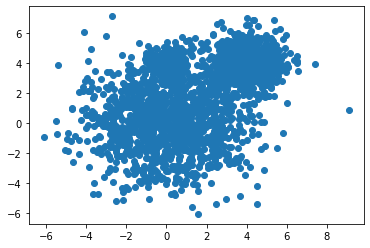

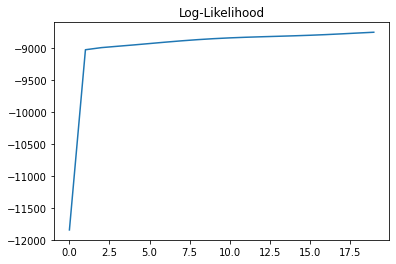

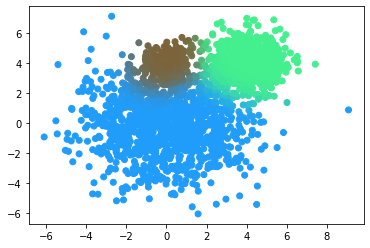

pi: [0.30336755 0.14084192 0.55579053]
means: [[ 3.96697794e+00  4.00285631e+00]
 [ 3.19669800e-03  3.76481071e+00]
 [ 3.31465013e-02 -2.38660066e-01]]
covariances: [[[ 1.06184805  0.01808622]
  [ 0.01808622  1.11448899]]

 [[ 0.53089358  0.14389422]
  [ 0.14389422  0.69921498]]

 [[ 4.25770775 -0.1819546 ]
  [-0.1819546   3.62736002]]]


In [ ]:
def main():
    # assume 3 means
    D = 2 # so we can visualize it more easily
    s = 4 # separation so we can control how far apart the means are
    mu1 = np.array([0, 0])
    mu2 = np.array([s, s])
    mu3 = np.array([0, s])

    N = 2000 # number of samples
    X = np.zeros((N, D))
    X[:1200, :] = np.random.randn(1200, D)*2 + mu1
    X[1200:1800, :] = np.random.randn(600, D) + mu2
    X[1800:, :] = np.random.randn(200, D)*0.5 + mu3

    # what does it look like without clustering?
    plt.scatter(X[:,0], X[:,1])
    plt.show()

    K = 3
    gmm(X, K)



if __name__ == '__main__':
    main()

Using GMM on MNIST dataset

In [ ]:
import pandas as pd
from datetime import datetime
# from gmm import gmm
from sklearn.mixture import GaussianMixture


Parameter to be considered for calculating performance 

In [ ]:
def get_data(limit=None):
    print("Reading in and transforming data...")
    df = pd.read_csv('/content/sample_data/mnist_train_small.csv')
    data = df.values
    np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y






def purity(Y, R):
    # maximum purity is 1, higher is better
    N, K = R.shape
    p = 0
    for k in range(K):
        best_target = -1 # we don't strictly need to store this
        max_intersection = 0
        for j in range(K):
            intersection = R[Y==j, k].sum()
            if intersection > max_intersection:
                max_intersection = intersection
                best_target = j
        p += max_intersection
    return p / N

def DBI(X, M, R):
    # ratio between sum of std deviations between 2 clusters / distance between cluster means
    # lower is better
    N, D = X.shape
    K, _ = M.shape

    # get sigmas first
    sigma = np.zeros(K)
    for k in range(K):
        diffs = X - M[k] # should be NxD
        squared_distances = (diffs * diffs).sum(axis=1) # now just N
        weighted_squared_distances = R[:,k]*squared_distances
        sigma[k] = np.sqrt( weighted_squared_distances.sum() / R[:,k].sum() )

    # calculate Davies-Bouldin Index
    dbi = 0
    for k in range(K):
        max_ratio = 0
        for j in range(K):
            if k != j:
                numerator = sigma[k] + sigma[j]
                denominator = np.linalg.norm(M[k] - M[j])
                ratio = numerator / denominator
                if ratio > max_ratio:
                    max_ratio = ratio
        dbi += max_ratio
    return dbi / K

Main function to run code

In [ ]:
def main():
    X, Y = get_data(10000)
    print("Number of data points:", len(Y))

    model = GaussianMixture(n_components=10)
    model.fit(X)
    M = model.means_
    R = model.predict_proba(X)

    print("Purity:", purity(Y, R)) # max is 1, higher is better
    print("DBI:", DBI(X, M, R)) # lower is better


if __name__ == "__main__":
    main()

Reading in and transforming data...
Number of data points: 10000
Purity: 0.5311988758517038
DBI: 3.192989349722776
